In [1]:
import pandas as pd
import spacy
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from internal_displacement.pipeline import SQLArticleInterface
# from nltk import StanfordNERTagger
# from nltk.tokenize import word_tokenize

# st_ner = StanfordNERTagger("/home/james/stanford-ner-2016-10-31/classifiers/english.all.3class.distsim.crf.ser.gz",
#                           "/home/james/stanford-ner-2016-10-31/stanford-ner.jar",
#                           encoding="utf-8")

**Manually created some reports to compare with extracted data**

**Extracting locations, reporting terms, reporting units, and quantities from raw text: **

- Use spacy to detect tokens referring to location.

- Tokens tagged with location are used as the location name. 

- If multiple tokens are tagged with a location, the token closest to the reporting term is used. If a location is not detected in the reporting term sentence, the previous sentence (if there is one) is examined for a location token. The parse tree is constructed for the preceding sentence, and the location closest to the sentence root is extracted.


**Issues/possible solutions**: 
    
- Situations where two locations are referred to in equal standing (eg "At least 24 people also died in two other eastern border provinces, Khost and Nangarhar, according to local officials. More than fifty homes and shops were destroyed and thousands of acres of farmland flooded") will result in only the first being extracted. 
    If multiple tokens are at the same distance from the root or reporting term, and this distance is the minimal distance between location and root/reporting term tokens, could try using all of them

- Should have structured reports on a per article basis, to make it easier to read and interpret them.




**Extracted Data will require a suitable data structure**

In [41]:
class Report:
    def __init__(self,place,date_time,event_term,subject_term,quantity,story):
        self.place = place
        self.date_time = date_time
        self.event_term = [t.lemma_ for t in nlp(event_term)][0]
        self.subject_term = subject_term
        self.quantity = quantity
        self.story = story
    def show_story_tree(self):
        self.display()
        for sentence in nlp(self.story).sents:
            for token in sentence:
                if token.lemma_ == self.event_term:
                    return to_nltk_tree(sentence.root)
    def display(self):
        print("Place: {}  DateTime: {}  EventTerm: {}  SubjectTerm:  {}  Quantity: {}"
              .format(self.place,self.date_time,self.event_term,self.subject_term,self.quantity))

**Developing the information extraction system will require training data for the evaluation of accuracy. Reports can be manually created.**

In [3]:
pipeline = SQLArticleInterface("../sql_db.sqlite") #Connecting to pre-populated database.

In [4]:
from nltk import Tree
def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_
nlp = spacy.load('en')

In [5]:
ground_truth_reports = []

In [6]:
labels,features = pipeline.get_training_data()

In [7]:
features[0]

"Flash flooding across Afghanistan and Pakistan has left more than 160 dead and dozens stranded in one of South Asia's worst natural disasters this year, say officials.  The flooding, caused by unusually heavy rain, has left villagers stuck in remote areas without shelter, food or power.  Mountainous Afghanistan was the worst hit, with 61 people killed and approximately 500 traditional mud-brick homes washed away in more than a dozen villages in Sarobi, a rural district less than an hour from Kabul, officials said.  Floods left a village devastated in the remote eastern Afghan province of Nuristan. At least 60 homes were destroyed across three districts, said provincial spokesman Mohammad Yusufi. No one was killed.  Authorities have been unable to deliver aid to some badly affected villages by land as roads in the area are controlled by the Taliban, Yusufi added.  “We have asked the national government for help as have an overwhelming number of locals asking for assistance, but this is

In [8]:
reports = [
    Report("Sarobi","","washed away","home",500,features[0]),
    Report("Nuristan","","devastated","village","a",features[0]),
    Report("Nuristan","","destroyed","home",60,features[0]),
    Report("Khost and Nangarhar","","destroyed","home","fifty",features[0]),
    Report("Pakistan","","house","collapsed","",features[0])
    ]
ground_truth_reports.extend(reports)

In [9]:
features[4]

'Afghanistan state news agency, Bakhtar News Agency (BNA) report that at least 7 people have been killed in flash floods in Faryab Province in the north of the country. Flash floods in Baghlan Province have killed 1 person and injured around 10 others.  Flash floods struck on 08 May 2015 in Faryab Province after a period of heavy rainfall. The districts of Garyzan, Pashtunkot and Belcheragh were worst affected. BNA report that at least 7 people were killed and over 1,500 homes damaged. The Faizabada-Takhar highway have been closed to traffic and wide areas of crops and orchards have suffered damaged.  Kuwaiti News Agency (KUNA) also report that flooding struck in the Baghlan-i-Markazi district of Baghlan province, where 1 person was killed and several injured early on Saturday 09 May 2015.  “There was heavy rain in Baghlan-e-Markazi district Friday evening and the people left their houses to safer areas. It was early Saturday when a flash flood hit the area and washed away more than 50

In [10]:
reports = [
    Report("Pashtunkot and Belcheragh","","damaged","home",1500,features[4]),
    Report("Baghlan-e-Markazi","Saturday","washed_away","house",500,features[4])
]
ground_truth_reports.extend(reports)

In [11]:
features[5]

'ALGIERS (AA) – Hundreds of homes have been destroyed in Algeria‘s southern city of Tamanrasset following several days of torrential rainfall, a local humanitarian aid official said Wednesday.  The city was pounded by rainfall from March 19 to March 24, according to Ghanom Sudani, a member of a government-appointed humanitarian aid committee.  He added that heavy rains had destroyed as many as 400 residences.  “Hundreds of families have had to leave their homes after they were inundated with water,” Sudani told The Anadolu Agency.  www.aa.com.tr/en  Last month neighbouring Tunisia experienced heavy rainfall and flooding in Jendouba City.'

In [12]:
reports = [
    Report("Tamanrasset","Wednesday","destroyed","home","Hundreds",features[5]),
    Report("Tamanrasset","","destroyed","home",400,features[5])
]
ground_truth_reports.extend(reports)

In [13]:
features[6]

'Flash floods have struck once again in the Badakhshan province of Afghanistan.  According to reports from Chinese state news agency, Xinhua, flash floods struck in the Kofab district of Badakhshan province on Saturday, 25 July 2015. Six people, including women and children, were reported as killed in the floods.  Quoting an official from the Badakhshan provincial government, Xinhua also said that the foods had damaged or destroyed more than 120 houses in the district. The official added that authorities were trying to provide necessary assistance to the affected people.  This is the second time this month that Badakhshan has seen deadly flash floods. Flash floods struck in the Shuhada district of Badakhshan on 07 July 2015, leaving at least 7 dead and around 300 families affected. Since then the International Organization for Migration (IOM) in Afghanistan have been distributing aid and relief for the flood-affected families in Shuhada.'

In [14]:
reports = [
    Report("Kofab","Saturday, 25 July 2015","destroyed","house",120,features[6]),
    Report("Shuhada","07 July 2015","affected","family",300,features[6])
]
ground_truth_reports.extend(reports)

In [15]:
features[7]

'Heavy rain on Monday 09 March 2015 flooded at least 3 municipalities of Luanda, the capital of Angola.  According to Angola news agency ANGOP, Luanda fire department have reported the flooding has forced at least 800 families from their homes. Later reports suggest that as many as 1,770 homes have been damaged. The municipalities of Viana, Cacuaco and Belas are said to be the worst affected.  Some streets have been completely blocked by the floods, making it difficult for the authorities to carry out full assessments of the damage. Provincial deputy governor for technical area, Agostinho da Silva, told ANGOP that the government are providing assistance to those in flood affected areas, and have set up pumps to help remove the flood water.'

In [16]:
reports = [
    Report("Luanda","Monday 08 March 2015","forced","family",300,features[7]),
    Report("Luanda","Monday 08 March 2015","destroyed","home",1770,features[7])
]
ground_truth_reports.extend(reports)

In [17]:
features[11]

'The information is contained in a report on the consequences of the rains, released by the Civil Protection commission for the municipalities of Sumbe and Porto Amboim.  According to the report presented by the secretary of State for Local Administration, Fernando Pontes Pereira, who travelled to the region for the purpose, the situation requires strong measures to relocate the people affected into safer places.  The report reads that the rains of March 28 and 29 left 2,160 people from Sumbe and Porto Amboim in a situation of dire need, as one was killed, three wounded and 150 houses destroyed, laving 483 homeless.  The source adds that Cuanza Sul Government is currently busy transferring those affected to safer places in the localities of Pomba Nova , near Sumbe, where tents have been installed for the purpose.'

In [18]:
reports = [
    Report("Sumbe and Porto Amboim","March 28","left","people",2160,features[11]),
    Report("Sumbe and Porto Amboim","March 28","destroy","house",150,features[11]),
]
ground_truth_reports.extend(reports)

Place: Sumbe and Porto Amboim  DateTime: March 28  EventTerm: destroy  SubjectTerm:  house  Quantity: 150


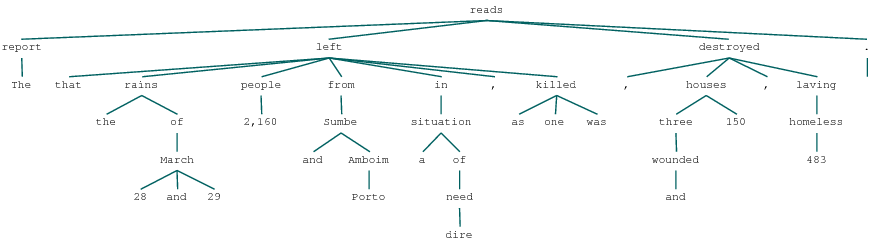

In [19]:
ground_truth_reports[-1].show_story_tree()

In [20]:
ground_truth_reports[-4].story

'Heavy rain on Monday 09 March 2015 flooded at least 3 municipalities of Luanda, the capital of Angola.  According to Angola news agency ANGOP, Luanda fire department have reported the flooding has forced at least 800 families from their homes. Later reports suggest that as many as 1,770 homes have been damaged. The municipalities of Viana, Cacuaco and Belas are said to be the worst affected.  Some streets have been completely blocked by the floods, making it difficult for the authorities to carry out full assessments of the damage. Provincial deputy governor for technical area, Agostinho da Silva, told ANGOP that the government are providing assistance to those in flood affected areas, and have set up pumps to help remove the flood water.'

**Automated Data Extraction **

In [23]:
reporting_terms = [
    'displaced', 'evacuated', 'forced flee', 'homeless', 'relief camp',
    'sheltered', 'relocated', 'destroyed housing', 'partially destroyed housing',
    'uninhabitable housing','stranded','stuck','stranded','washed','swept','damaged','collapsed'
]

people_reporting_units = [
    'people', 'persons','lives', 'individuals', 'children', 'inhabitants', 'residents', 'migrants','dead','fatalities','casualties','deaths'
]

structure_reporting_units = [
    'families', 'households', 'houses', 'homes','dwelling','hut'
]
#Converting to lemmas to allow matching.
reporting_term_lemmas = [t.lemma_ for t in nlp(" ".join(reporting_terms))]
structure_unit_lemmas = [t.lemma_ for t in nlp(" ".join(structure_reporting_units))]
unit_lemmas = [t.lemma_ for t in nlp(" ".join(structure_reporting_units + people_reporting_units))]

In [36]:
def is_reporting_term_lemma_present(sentence):
    sentence_lemmas = [token.lemma_ for token in sentence]
    return any([sl in reporting_term_lemmas for sl in sentence_lemmas])

def drill_down_from_term(term_token):
    reports = []
    children = term_token.children
    unit_children = list(filter(lambda x: x.lemma_ in structure_unit_lemmas,children))
    for uc in unit_children:
        uc_children = uc.children
        for token in uc_children:
            if token.like_num:
                numerical_term = token
                reporting_unit = uc
                reporting_term = term_token
                report = Report(reporting_term,reporting_unit,number)
                reports.append(report)
    return reports
def get_all_descendent_tokens(token):
    """
    Returns a list of all descendents of the specified token.
    """
    children_accum = []
    for child in token.children:
        children_accum.append(child)
        grandchildren = get_all_descendent_tokens(child)
        children_accum.extend(grandchildren)
    return children_accum


def check_prior_sentence_for_locations(sentence):
    """
    It seems like locations are often mentioned in the sentence preceding the reporting term sentence.
    This function scans a sentence and extracts the highest placed location (if present) in the parse tree.
    """
    location = ""
    root_word = sentence.root
    sentence_tokens = [root_word] + get_all_descendent_tokens(root_word)
    for token in sentence_tokens:
        if token.ent_type_ =="GPE":
            location = token.text
            break #I suspect the true location will have the highest position in the parse graph.
    return location
            
def find_reports(story):
    reports = []
    sentences = list(nlp(story).sents)
    for i,sentence in enumerate(sentences):
        for token in sentence:
            if token.lemma_ in reporting_term_lemmas:
                term_token = token
                token_descendents = get_all_descendent_tokens(term_token)
                
                location = ""
                for desc_token  in token_descendents:
                    if desc_token.ent_type_ == "GPE":
                        location = desc_token.text
                        break   # If multiple locations are detected amongst reporting term descendents, 
                                # use the location token closest to the reporting term token.
                if location == "":
                    if i > 0:
                        location = check_prior_sentence_for_locations(sentences[i-1])
                children = term_token.children
                unit_children = list(filter(lambda x: x.lemma_ in unit_lemmas,children))
                for uc in unit_children:
                    uc_children = uc.children
                    for token in uc_children:
                        if token.like_num:
                            number = token
                            reporting_unit = uc
                            reporting_term = term_token
                            report = Report(location,"",reporting_term.text,reporting_unit.text,number.text,sentence.text)
                            reports.append(report)
                            report.display()
    return reports

In [37]:
find_reports(ground_truth_reports[0].story)

Place: Sarobi  DateTime:   EventTerm: wash  SubjectTerm:  homes  Quantity: 500
Place: Nuristan  DateTime:   EventTerm: destroy  SubjectTerm:  homes  Quantity: 60
Place: Khost  DateTime:   EventTerm: destroy  SubjectTerm:  homes  Quantity: fifty


In [38]:
ground_truth_reports[0].display()

Place: Sarobi  DateTime:   EventTerm: wash  SubjectTerm:  home  Quantity: 500


In [127]:
ground_truth_reports[0].story

"Flash flooding across Afghanistan and Pakistan has left more than 160 dead and dozens stranded in one of South Asia's worst natural disasters this year, say officials.  The flooding, caused by unusually heavy rain, has left villagers stuck in remote areas without shelter, food or power.  Mountainous Afghanistan was the worst hit, with 61 people killed and approximately 500 traditional mud-brick homes washed away in more than a dozen villages in Sarobi, a rural district less than an hour from Kabul, officials said.  Floods left a village devastated in the remote eastern Afghan province of Nuristan. At least 60 homes were destroyed across three districts, said provincial spokesman Mohammad Yusufi. No one was killed.  Authorities have been unable to deliver aid to some badly affected villages by land as roads in the area are controlled by the Taliban, Yusufi added.  “We have asked the national government for help as have an overwhelming number of locals asking for assistance, but this is

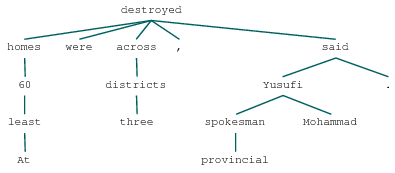

In [134]:
ground_truth_reports[2].show_story_tree()

In [149]:
print(ground_truth_reports[5].story)
find_reports(ground_truth_reports[5].story)

Afghanistan state news agency, Bakhtar News Agency (BNA) report that at least 7 people have been killed in flash floods in Faryab Province in the north of the country. Flash floods in Baghlan Province have killed 1 person and injured around 10 others.  Flash floods struck on 08 May 2015 in Faryab Province after a period of heavy rainfall. The districts of Garyzan, Pashtunkot and Belcheragh were worst affected. BNA report that at least 7 people were killed and over 1,500 homes damaged. The Faizabada-Takhar highway have been closed to traffic and wide areas of crops and orchards have suffered damaged.  Kuwaiti News Agency (KUNA) also report that flooding struck in the Baghlan-i-Markazi district of Baghlan province, where 1 person was killed and several injured early on Saturday 09 May 2015.  “There was heavy rain in Baghlan-e-Markazi district Friday evening and the people left their houses to safer areas. It was early Saturday when a flash flood hit the area and washed away more than 500

[<__main__.Report at 0x7ff966dd9748>, <__main__.Report at 0x7ff966dd9cc0>]

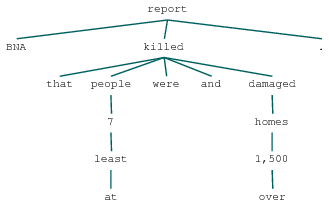

In [150]:
ground_truth_reports[5].show_story_tree()

In [42]:
for gtr in ground_truth_reports:
    print("Ground Truth:")
    gtr.display()
    print("Extracted Reports:")
    reports = find_reports(gtr.story)
    for r in reports:
        r.display()
    print("----------------------")

Ground Truth:
Place: Sarobi  DateTime:   EventTerm: wash  SubjectTerm:  home  Quantity: 500
Extracted Reports:
Place: Sarobi  DateTime:   EventTerm: wash  SubjectTerm:  homes  Quantity: 500
Place: Nuristan  DateTime:   EventTerm: destroy  SubjectTerm:  homes  Quantity: 60
Place: Khost  DateTime:   EventTerm: destroy  SubjectTerm:  homes  Quantity: fifty
Place: Sarobi  DateTime:   EventTerm: wash  SubjectTerm:  homes  Quantity: 500
Place: Nuristan  DateTime:   EventTerm: destroy  SubjectTerm:  homes  Quantity: 60
Place: Khost  DateTime:   EventTerm: destroy  SubjectTerm:  homes  Quantity: fifty
----------------------
Ground Truth:
Place: Nuristan  DateTime:   EventTerm: devastate  SubjectTerm:  village  Quantity: a
Extracted Reports:
Place: Sarobi  DateTime:   EventTerm: wash  SubjectTerm:  homes  Quantity: 500
Place: Nuristan  DateTime:   EventTerm: destroy  SubjectTerm:  homes  Quantity: 60
Place: Khost  DateTime:   EventTerm: destroy  SubjectTerm:  homes  Quantity: fifty
Place: Sarob